In [1]:
#Import packages
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier#Regressor
from dtreeviz.trees import *
from sklearn.model_selection import train_test_split
from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall
from joblib import dump, load
import time

%matplotlib inline

/home/nsourlos/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#Get path of a particular individual
path=os.getcwd() 
# file1a=path+'/'+'PAMAP2_Dataset/Optional/subject101.dat' 
file1b=path+'/'+'PAMAP2_Dataset/Protocol/subject101.dat' 

#Verification
filenew=path+'/'+'PAMAP2_Dataset/Protocol/subject103.dat' #gives max accuracy fro pat 107, for 102 only 1%!!

In [3]:
#Functions to calculate rmse and accuracy
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

def accur(pred,y):
    correct=0
    pred=np.round(pred,0)
    for i in range(len(pred)):
        if pred[i]==y[i]:
            correct+=1
    return correct/len(pred)

#Function to create random forests - n_estimators=number of trees, max_samples=no of rows to sample for each tree,
#max_features=no of columns to sample at each split (0.5=take half of columns), min_samples_leaf=when to stop 
#splitting, n_jobs=-1 to use all CPUs
def rf(xs, y, n_estimators=40, max_samples=10000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

#Functions to calculate the feature importance to the results
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

#The feature importance algorithm loops through each tree, and then recursively explores each branch. 
#At each branch, it looks to see what feature was used for that split, and how much the model improves 
#as a result of that split. The improvement (weighted by the number of rows in that group) is added to the 
#importance score for that feature. This is summed across all branches of all trees, and finally the scores
#are normalized such that they add to 1.

#Plot all the features along with their importance
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

#Function for processing data
def proces(file1b,param=0,rantree=0, derf=0): #param=1 means train new model, 0 means use trained model. 
    #rantree=1 means train a Random forest instead of decision tree, derf: decision tree (0) of rf (1)?
    if param==0 and derf==0: #If we want the pretrained decision tree
        m = load('filename.joblib') #Load the trained model
    elif param==0 and derf==1: #If we want the pretrained random forest
        m=load('filenamerf.joblib')
        
    
    # read .dat file to a list of lists
    datContenta = [i.strip().split() for i in open(file1b).readlines()]
#     datContentb = [i.strip().split() for i in open(file2b).readlines()] #####
    datContent=datContenta#+datContentb######
    
    #Set columns names manually
    columns_names=['timestamp (s)','activityID','heart rate(bpm)','hand temperature','hand 3D-accela','hand 3D-accelb',
                   'hand 3D-accelc','hand 3D-acceld', 'hand 3D-accele','hand 3D-accelf','hand 3D-gyroa','hand 3D-gyrob',
                   'hand 3D-gyroc','hand 3D-magneta','hand 3D-magnetb','hand 3D-magnetc','hand ora','hand orb',
                   'hand orc','hand ord', 'chest temperature','chest 3D-accela','chest 3D-accelb','chest 3D-accelc',
                   'chest 3D-acceld','chest 3D-accele','chest 3D-accelf','chest 3D-gyroa','chest 3D-gyrob',
                   'chest 3D-gyroc','chest 3D-magneta','chest 3D-magnetb','chest 3D-magnetc','chest ora','chest orb',
                   'chest orc','chest ord','ankle temperature','ankle 3D-accela','ankle 3D-accelb','ankle 3D-accelc',
                   'ankle 3D-acceld','ankle 3D-accele','ankle 3D-accelf','ankle 3D-gyroa','ankle 3D-gyrob',
                   'ankle 3D-gyroc','ankle 3D-magneta','ankle 3D-magnetb','ankle 3D-magnetc','ankle ora','ankle orb',
                   'ankle orc','ankle ord']
    
    # data=pd.DataFrame(datContent) #Make the list of lists a dataframe
    data=pd.DataFrame(datContent)
    data.columns=columns_names #Change the column names
    
#     len(columns_names)==len(datContent[0]) #Number of columns should match the len of each sublist (all have same length)
    
    data = data[data.activityID != '0'] #Drop rows for which activityID=0 based on description

    #Drop rows which include orientation - Invalid in this data collection (drop 4*3=12 columns)
    data=data[data.columns.drop(list(data.filter(regex='ora')))]
    data=data[data.columns.drop(list(data.filter(regex='orb')))]
    data=data[data.columns.drop(list(data.filter(regex='orc')))]
    data=data[data.columns.drop(list(data.filter(regex='ord')))]

    #Drop columns which may be saturated (drop 3*3=9 columns)
    data = data[data.columns.drop(list(data.filter(regex='acceld')))]
    data = data[data.columns.drop(list(data.filter(regex='accele')))]
    data = data[data.columns.drop(list(data.filter(regex='accelf')))]

#     data #Show data - Expected 54-12-9=33 columns

    data = data[data['heart rate(bpm)'] != 'NaN'] #Drop rows for which heart rate is NaN???????
    df2=data.astype(float) #Not strings so that it will be easy to plot them.
#     print(df2.info())

    #Next de-activate if above NaN activated
#     df2=df2.fillna(method='ffill') #Fill nan values with the above value that is not missing
    df2=df2[~df2.isnull().any(axis=1)] #Check if there is any missing value

    if param==1: #If we train a model
#1) Show raw data excerpts that exemplify the various activities and visually confirm  differences 
#in measurements related to these activities
        uniqueIDs=np.unique(df2['activityID']) #The unique classes
        columns_to_check=['heart rate(bpm)','ankle temperature'] #The variables to check

        for j in range(len(columns_to_check)): #Loop over list of variables to check
            for i in uniqueIDs: #Loop over unique classes
                act=df2[df2['activityID']==i][columns_to_check[j]] #keep only values of specific class and variable
                print('Activity {} - {} min {}, max {} and mean {}'.format(int(i),columns_to_check[j],
                                                                           np.min(act), np.max(act), np.mean(act)))
            print('\n')  
        

    train, test = train_test_split(df2, test_size=0.2) #Split data into 80% training and 20% test sets
    ##############################
    if param==1:
        traintime=train
        
        #Get corresponding columns of dataframe to plot below
        time=traintime['timestamp (s)']
        heart=traintime['heart rate(bpm)']
        activity=traintime['activityID']
        hand=traintime['hand temperature']
        chest=traintime['chest temperature']
        ankle=traintime['ankle temperature']

        #Show time series plots demonstrating changes in the property values

        #Time series plots
        ax = plt.subplot()
        plt.scatter(time,heart,s=0.01)
        plt.ylabel("heart rate (bpm)")
        plt.xlabel("time (s)")
        plt.show()

        ax = plt.subplot()
        plt.scatter(time,hand,s=0.01)
        plt.ylabel("hand temperature")
        plt.xlabel("time (s)")
        plt.show()

        ax = plt.subplot()
        plt.scatter(time,chest,s=0.01)
        plt.ylabel("chest temperature")
        plt.xlabel("time (s)")
        plt.show()

        ax = plt.subplot()
        plt.scatter(time,ankle,s=0.01)
        plt.ylabel("ankle temperature")
        plt.xlabel("time (s)")
        plt.show()

        #Scatter plots
#         fig, ax = plt.subplots(figsize=(20,10))
#         scatter = ax.scatter(traintime['hand temperature'],traintime['timestamp (s)'], s=5,c=traintime['activityID'])
#         ax.set(xlabel='hand temperature', ylabel='time (s)')
#         legend1 = ax.legend(*scatter.legend_elements(),loc="upper right", title="Classes")

#         fig, ax = plt.subplots(figsize=(20,10))
#         scatter = ax.scatter(traintime['hand temperature'],traintime['heart rate(bpm)'], s=5,c=traintime['activityID'])
#         ax.set(xlabel='hand temperature', ylabel='heart rate (bpm)')
#         legend1 = ax.legend(*scatter.legend_elements(),loc="upper right", title="Classes")
#         # ax.add_artist(legend1)
    
#         fig, ax = plt.subplots(figsize=(20,10))
#         scatter = ax.scatter(traintime['chest temperature'],traintime['heart rate(bpm)'], s=5,c=traintime['activityID'])
#         ax.set(xlabel='chest temperature', ylabel='heart rate (bpm)')
#         legend1 = ax.legend(*scatter.legend_elements(),loc="upper right", title="Classes")

        fig, ax = plt.subplots(figsize=(20,10))
        scatter = ax.scatter(traintime['ankle temperature'],traintime['heart rate(bpm)'], s=5,c=traintime['activityID'])
        ax.set(xlabel='ankle temperature', ylabel='heart rate (bpm)')
        legend1 = ax.legend(*scatter.legend_elements(),loc="upper right", title="Classes")

        fig, ax = plt.subplots(figsize=(20,10))
        scatter = ax.scatter(traintime['hand 3D-accela'],traintime['ankle 3D-accela'], s=5,c=traintime['activityID'])
        ax.set(xlabel='hand 3D-accela', ylabel='ankle 3D-accela')
        legend1 = ax.legend(*scatter.legend_elements(),loc="upper right", title="Classes")
        
        fig, ax = plt.subplots(figsize=(20,10))
        scatter = ax.scatter(traintime['chest 3D-magnetc'],traintime['ankle 3D-magnetc'], s=5,c=traintime['activityID'])
        ax.set(xlabel='chest 3D-magnetc', ylabel='ankle 3D-magnetc')
        legend1 = ax.legend(*scatter.legend_elements(),loc="upper right", title="Classes")
        
#         fig, ax = plt.subplots(figsize=(20,10))
#         scatter = ax.scatter(traintime['hand temperature'],traintime['ankle temperature'], s=5,c=traintime['activityID'])
#         ax.set(xlabel='hand temperature', ylabel='ankle temperature')
#         legend1 = ax.legend(*scatter.legend_elements(),loc="upper right", title="Classes")
        
#         fig, ax = plt.subplots(figsize=(20,10))
#         scatter = ax.scatter(traintime['hand temperature'],traintime['chest temperature'], s=5,c=traintime['activityID'])
#         ax.set(xlabel='hand temperature', ylabel='chest temperature')
#         legend1 = ax.legend(*scatter.legend_elements(),loc="upper right", title="Classes")
    ###############################
    
    #Select all the columns for training and test sets except the one with the timestamp (Time not relevant in general)
    train=train.loc[:, train.columns != 'timestamp (s)']
    test=test.loc[:, test.columns != 'timestamp (s)']
    
    xs=train.loc[:, train.columns != 'activityID'] #Get all columns as training data except the activityID
    y=train.loc[:, train.columns == 'activityID'] #Labels that we want to predict - activityID
    
    if param==1 and rantree==0: #If we train a decision tree
        print("We train a decision tree")
        m = DecisionTreeClassifier(min_samples_leaf=500)#, max_leaf_nodes=10)#max_depth=7)#,min_samples_split=400)
        #DecisionTreeRegressor(min_samples_leaf=1000,max_depth=5)
        # 10000 #max_leaf_nodes=15) #Initialize decision tree       
        m.fit(xs, y); #Fit the tree
        print("Depth of tree is")
        print(m.get_depth())
        
    
        fn=list(xs.columns) #Get the features - The columns of training data
        cn=np.unique(y) #Get the unique labels
        cn=[str(x) for x in cn] #Make labels strings

        fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300) #Make a plot
        tree.plot_tree(m,
                       feature_names = fn, 
                       class_names=cn,
                       filled = True); #Plot tree
        fig.savefig(file1b+'imagename.pdf',bbox_inches='tight') #Save figure
        
    #These are the properties/features which can be used to differentiate between activities
    
    
    vals=y.values # Get the labels from the series
    vals=np.concatenate(vals, axis=0) # Concatenate them so that we do not have an array of arrays
    
    if rantree==1: #If we want to train a rf
        print("We train a rf")
        m = rf(xs, vals)#vals); #Fit the random forest
        dump(m, 'filenamerf.joblib') #Save it
    
    print("RMSE is")
    print(m_rmse(m, xs, vals)) #rmse of training set
    print('Accuracy is')
    print(accur(m.predict(xs),vals)) #Accuracy of train set

#     print("Accuracy though scikit is") 
#     print(m.score(xs,vals)) #Same from scikit implementation
    
    
    valid_xs=test.loc[:, test.columns != 'activityID'] #Get all the columns of test set except of the activityID
    valid_y=test.loc[:, test.columns == 'activityID'] #Get the column with the labels of the test set
    valid_y=valid_y.values # Get the labels from the series
    valid_y=np.concatenate(valid_y, axis=0 ) # Concatenate them so that we do not have an array of arrays
    print("RMSE of validation set")
    print(m_rmse(m, valid_xs, valid_y)) #rmse of test set
    print("Accuracy of validation set")
    print(accur(m.predict(valid_xs),valid_y)) #Accuracy of val set
#     print("Accuracy though scikit is")
#     print(m.score(valid_xs,valid_y)) #Same from scikit implementation


    if rantree==0 and derf==0: #If we have a decision tree
        print("Total number of leaves and number of rows are")
        print(m.get_n_leaves(), len(xs)) #Show number of leaves and the total rows of training set
    
    if rantree==1: #If we train an rf
        #plot of how the rmse changes by adding more trees 
        preds = np.stack([t.predict(valid_xs) for t in m.estimators_])
        plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);
    
    fi = rf_feat_importance(m, xs)
    
    if param==1: #If we train plot the 30 most important features
        plot_fi(fi[:30]);

    
    if rantree==1: #If we train a random tree
        #Select to keep only the features with weight above a threshold value
        to_keep = fi[fi.imp>0.005].cols
        len(to_keep)

        #Keep only the important features
        xs_imp = xs[to_keep]
        valid_xs_imp = valid_xs[to_keep]
        m = rf(xs_imp, vals) #Fit the random forest using only the important features

        #Show the rmse and accuracy for training and test set with the important features only
        print("RMSE of reduced train and val data")
        print(m_rmse(m, xs_imp, vals), m_rmse(m, valid_xs_imp, valid_y)) 
        print("accuracy of reduced train and val data")
        print(accur(m.predict(xs_imp),vals), accur(m.predict(valid_xs_imp),valid_y))
        
        plot_fi(rf_feat_importance(m, xs_imp)); #Plot the important features only

        row = xs_imp.iloc[:5] #Select the first 5 most important features

        #Show how much each feature contributes to the final result as a graph
        prediction,bias,contributions = treeinterpreter.predict(m, row.values)
        waterfall(xs_imp.columns, contributions[0], threshold=0.08, 
                  rotation_value=45,formatting='{:,.3f}');
    
    if param==1 and rantree==0: #If we trained a decision tree
        dump(m, 'filename.joblib') #Save the trained model

Activity 1 - heart rate(bpm) min 78.0, max 107.0 and mean 87.52877263581489
Activity 2 - heart rate(bpm) min 83.0, max 109.0 and mean 91.18321678321678
Activity 3 - heart rate(bpm) min 95.0, max 112.0 and mean 103.40994419076611
Activity 4 - heart rate(bpm) min 112.0, max 127.0 and mean 120.4844467108618
Activity 5 - heart rate(bpm) min 124.0, max 176.0 and mean 161.38733509234828
Activity 6 - heart rate(bpm) min 119.0, max 135.0 and mean 127.22356776897998
Activity 7 - heart rate(bpm) min 111.0, max 147.0 and mean 139.66465753424657
Activity 12 - heart rate(bpm) min 113.0, max 169.0 and mean 144.29910406616128
Activity 13 - heart rate(bpm) min 123.0, max 170.0 and mean 138.63362701908957
Activity 16 - heart rate(bpm) min 107.0, max 140.0 and mean 130.23408329344184
Activity 17 - heart rate(bpm) min 93.0, max 106.0 and mean 99.51560316721006
Activity 24 - heart rate(bpm) min 128.0, max 183.0 and mean 165.65557553956833


Activity 1 - ankle temperature min 30.75, max 32.375 and mean 31.

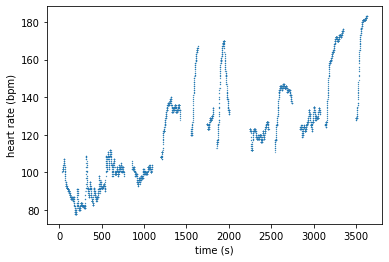

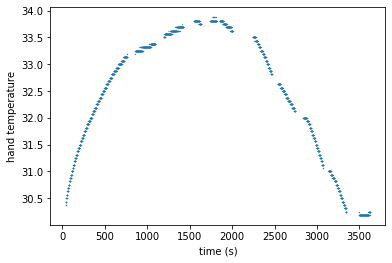

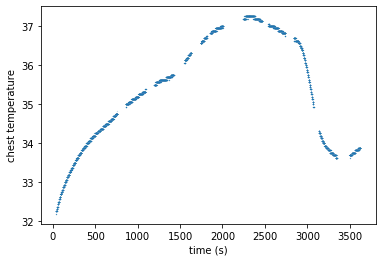

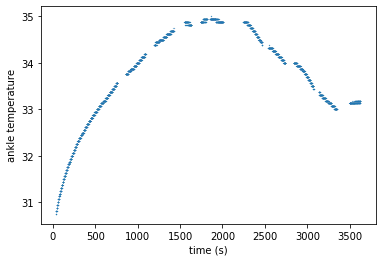

We train a rf
RMSE is
0.139609
Accuracy is
0.996071270473661
RMSE of validation set
0.104994
Accuracy of validation set
0.9940239043824701
RMSE of reduced train and val data
0.143616 0.109174
accuracy of reduced train and val data
0.995075254537406 0.9920318725099602
Time run
23.86086416244507


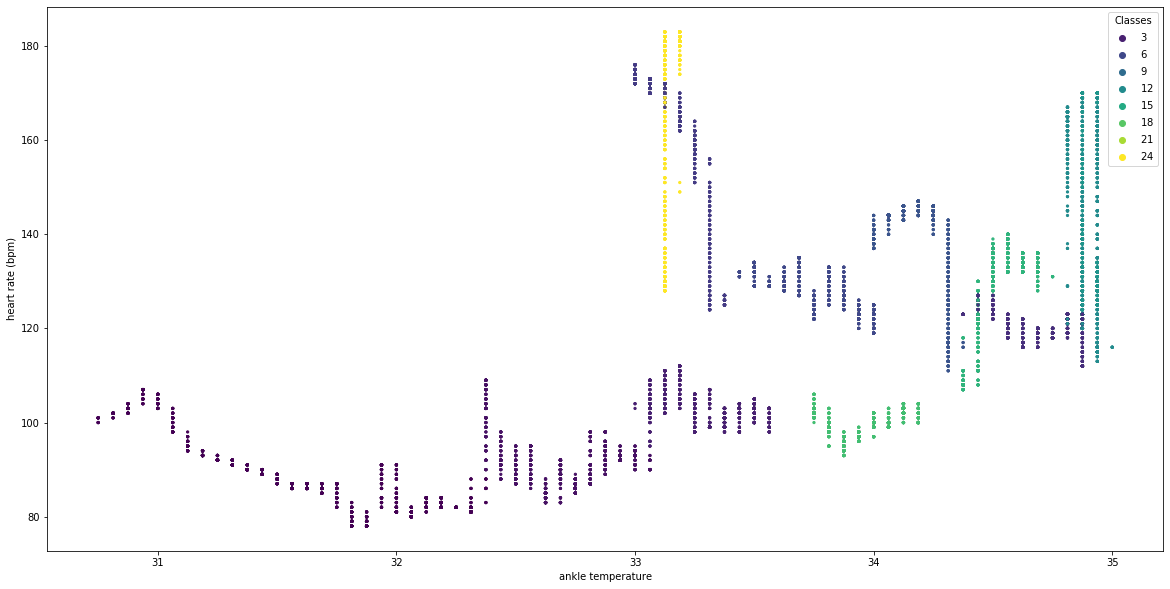

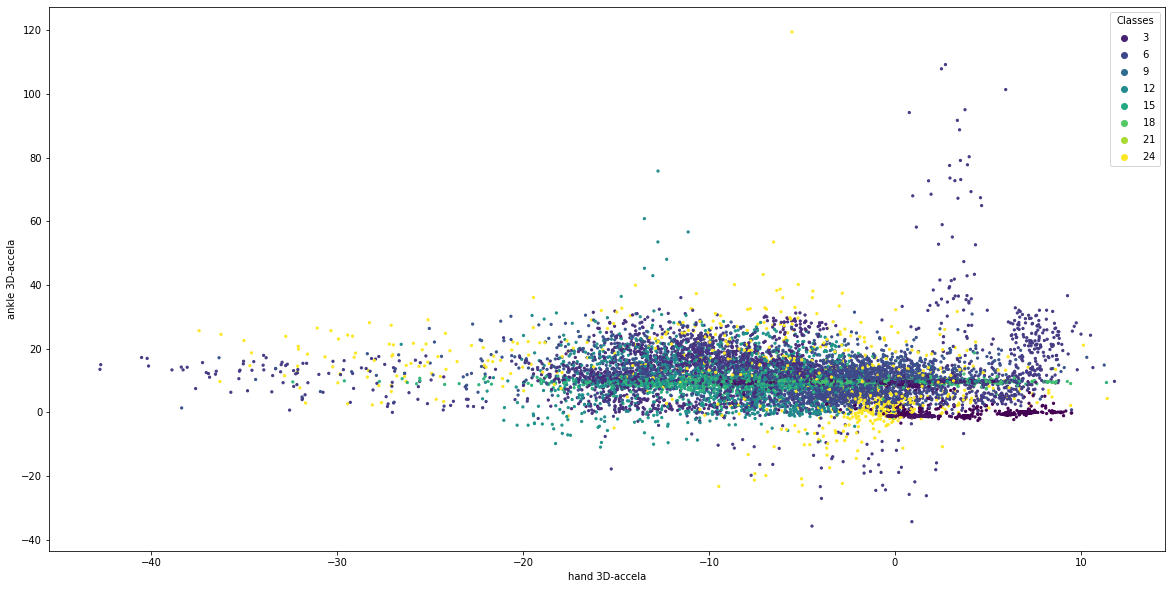

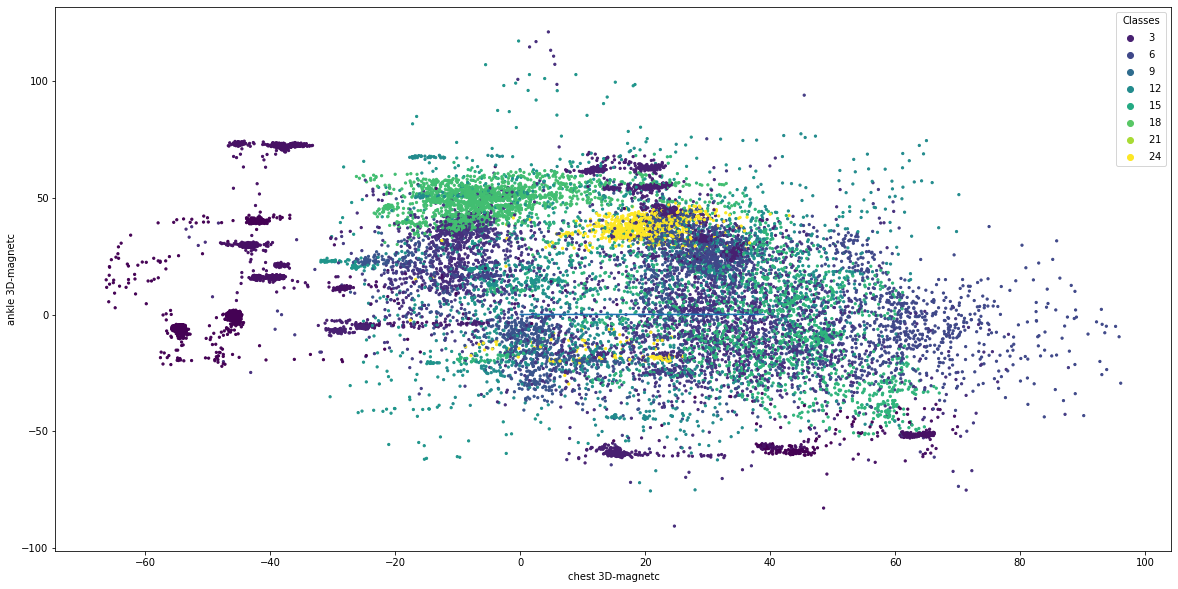

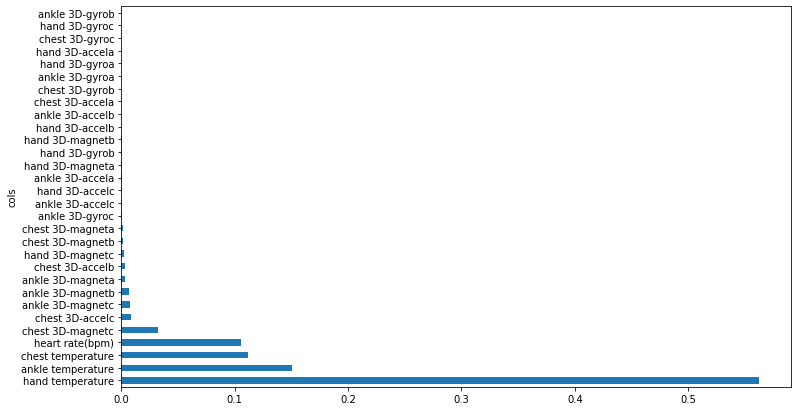

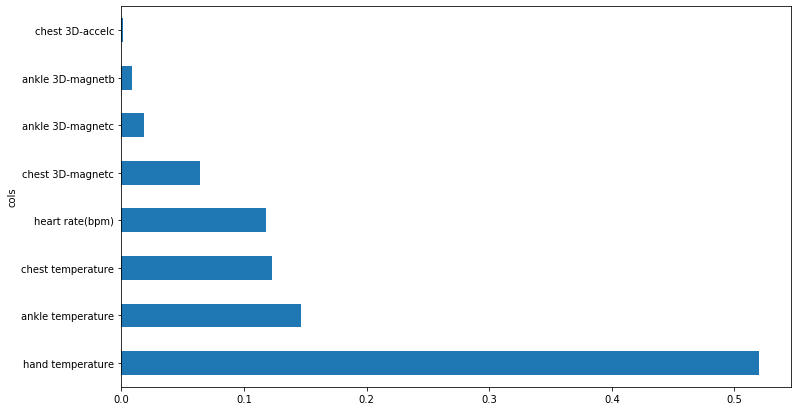

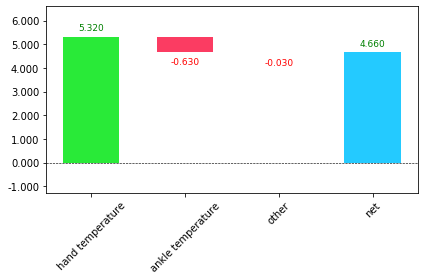

In [4]:
start=time.time()
# proces(file1b,1,0,0) #train dec
proces(file1b,1,1,0) #train rf

#param=1 means train new model, 0 means use trained model. 
#rantree=1 means train a Random forest instead of decision tree, derf: decision tree (0) of rf (1)?

end=time.time()
print("Time run")
print(end-start) #Print time it took to run

From the above we can confirm that eg. for activity 1 and 24 there are great differences in all the above metrics for both the heart rate and the ankle temperature. Extracted properties are shown on decision tree

In [5]:
start=time.time()
# proces(filenew) #test dc
proces(filenew,derf=1) #test rf
end=time.time()
print("Time run")
print(end-start) #Print time it took to run

RMSE is
7.263695
Accuracy is
0.18016098484848486
RMSE of validation set
7.338012
Accuracy of validation set
0.17229409908488483
Time run
14.052455425262451


Other approaches that could be tried are nn. Preprocessing like normalization could help improve the generalization performance of our algorithms.